# Convolutional Neural Network

## Introdution

## Flowchart

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

D:\Software\Anaconda\envs\tft\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Configuration of neural network

In [3]:
# 两个卷积层，然后一个全连接层

# Convolutional layer 1
filter_size1 = 5
num_filters1 = 16

# convilutional layer 2
filter_size2 = 5
num_filers2 = 36

# fully connected layer
fc_size = 128

## Load Data

In [7]:
from mnist import MNIST
data = MNIST(data_dir="data/MNIST")

# check the data-set
print("Size of:")
print("- Train data-set:\t {}".format(data.x_train.shape))
print("- Test data-set:\t {}".format(data.x_test.shape))
print("- Val data-set:\t\t {}".format(data.x_val.shape))

Size of:
- Train data-set:	 (55000, 784)
- Test data-set:	 (10000, 784)
- Val data-set:		 (5000, 784)


In [9]:
img_size = data.img_size # 图像在每一个通道的每一维的像素点的数量
img_size_flat = data.img_size_flat # 图像在每一个通道的像素斯安总数
# print(img_size,img_size_flat)

img_shape = data.img_shape
num_classes = data.num_classes

num_channels = data.num_channels


In [10]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)       
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])  
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

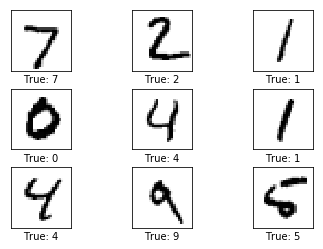

In [11]:
images = data.x_test[:9]
cls_true = data.y_test_cls[:9]
plot_images(images,cls_true)

## Tensorflow Graph

### Helper-function for creating new variables

In [12]:
# define the shape, and the form of initialization
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape,stddev=0.05))
    
def new_bias(length):
    return tf.Variable(tf.constant(0.05,shape=[length]))

### Helper function for creating new conv layer  

In [14]:
# 仅仅是定义了这么一些东西，而非实际的定义，还没有传入一个session
# input.shape = [N,W,H,C]
def new_conv_layer(input,              # The input from the last layer
                  num_input_channels,  # The input channels
                  filter_size,         # The filter size weight=height
                  num_filters,         # The filter num, the num of channels of nest layer
                  use_pooling=True):    # whetcher to pooling
    # 定义这一卷积层的weight的形状
    # The tf format :[filter宽，filter高，上一层channel,下一层channels]
    shape = [filter_size,filter_size,num_input_channels,num_filters]
    weights = new_weights(shape=shape)
    biase = new_bias(num_filters)
    # 进行卷积操作
    layer = tf.nn.conv2d(input=input,
                        filter=weights,
                        strides=[1,1,1,1],
                        padding='SAME') + biase
    # 是否需要池化
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                              ksize=[1,2,2,1],
                              strides=[1,2,2,1],
                              padding='SAME')
    # 传入激活函数进行计算
    layer = tf.nn.relu(layer)
    return layer,weights
    

### Helper-function for flattening a layer

In [22]:
# 作用将一个四维向量转换为一个2维向量
def flatten_layer(input):
    # 不是应该有tf.nn的函数接口吗
    layer_shape = input.get_shape()
    num_features = layer_shape[1:4].num_elements() # 使用了tf unfc
    layer_flat = tf.reshape(input,[-1,num_features])
    return layer_flat,num_features

### Helper-function for create a fully-connected Layer
[numimages,input_dim] --> [num_images,output_dim]

In [16]:
def new_fc_layer(input,
                input_dims,
                output_dims,
                use_relu=True):
    shape = (input_dims,output_dims)
    weights = new_weights(shape=shape)
    biases = new_bias(length=output_dims)
    layer = tf.matmul(input,weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

### Placeholder Variables

In [18]:
x = tf.placeholder(tf.float32,[None,img_size_flat])
# 转换为图像数据格式
x_image = tf.reshape(x,[-1,img_size,img_size,num_channels])

# y表示最开始给随着图像数据一起输入到模型时的标签
y_true = tf.placeholder(tf.float32,[None,num_classes]) #一维向量
y_true_cls = tf.argmax(y_true,1)

### Convolutional layer

In [20]:
# Convolutional layer1
layer_conv1,weigths_conv1 = new_conv_layer(input=x_image,
                                           num_input_channels=num_channels,
                                           filter_size=filter_size1,
                                           num_filters=num_filters1,
                                           use_pooling=True)

# Convolutional layer 2
layer_conv2,weigths_conv2 = new_conv_layer(input=layer_conv1,
                                          num_input_channels=num_filters1,
                                          filter_size=filter_size2,
                                          num_filters=num_filers2,
                                          use_pooling=True)

### Fully-Connected layer

In [23]:
# 先进行转换
layer_flat,num_features = flatten_layer(layer_conv2)

# 第一全连接层
layer_fc1 = new_fc_layer(input=layer_flat,
                        input_dims=num_features,
                        output_dims=fc_size,
                        use_relu=True)

# 第二全连接层
layer_fc2 = new_fc_layer(input=layer_fc1,
                        input_dims=fc_size,
                        output_dims=num_classes,
                        use_relu=True)

### Predicted Class

In [24]:
# y 的预测值 [0,1,0,0,0,0,0]
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred,1)

### Cost function

In [25]:
# 输入预测的[0,1,0,0,0,0] 与真实的[0,1,0,0,0,0]进行求交叉熵函数损失
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,
                                                          labels=y_true)

### Optimizer method

In [26]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cross_entropy)

### Performance Measures

In [27]:
# 将预测的标签与真实的标签进行比较
correct_predict = tf.equal(y_pred_cls,y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_predict,tf.float32))


以上的定义了整个二层卷积网络的结构，需要的变量，代价函数，求解器，误差表示

## Tensorflow Run

### Initailization

In [36]:
session = tf.Session()
session.run(tf.global_variables_initializer())

### Optimization

In [41]:
batch_size = 64
total_iterations = 0

# helper function for optimization
def optimize(num_iterations):
    tic = time.time()
    global total_iterations
    for i in range(total_iterations,
                   total_iterations+num_iterations):
        batch_x,batch_y,_ = data.random_batch(batch_size=batch_size)
        feed_dict_train = {x:batch_x,
                          y_true:batch_y}
        session.run(optimizer,feed_dict=feed_dict_train)
        if i%100 == 0:
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            acc = session.run(accuracy,feed_dict=feed_dict_train)
            print(msg.format(i+1,acc))
    total_iterations += num_iterations
    toc = time.time()
    time_diff = toc-tic
    print("Time usage: "+str(timedelta(seconds=int(round(time_diff)))))
    
# 是没有专门的预测函数进行对输入进行输出的预测，而是按照训练的时候一样输入数据
# 但是此时就不要输入y_true因为没有用到损失函数，仅仅传入X就行，
# 但也可以传入y但是不要运行optimizer，不然会再进行优化
# 可以传入y进行精度的运算

# helper-function for printing the test acc
def print_test_accuaracy(plot_confusion_matrix_=False):
    x_test = data.x_test
    y_test_true_cls = data.y_test_cls
    feed_dict_test = {x:x_test}
    y_test_pred_cls = session.run(y_pred_cls,feed_dict=feed_dict_test)
    correct_sum = (y_test_true_cls==y_test_pred_cls).sum()
    test_sum = data.num_test
    acc = float(correct_sum)/test_sum
    print("Accuracy on test set:{0:.1%} ({1}/{2})".format(acc,correct_sum,test_sum))
    
    if plot_confusion_matrix:
        plot_confusion_matrix(y_test_true_cls,y_test_pred_cls)
    

# helper function for plotting confusion matrix
def plot_confusion_matrix(y_true,y_pred):
    cm = confusion_matrix(y_true=y_true,
                         y_pred=y_pred)
    print(cm)
    plt.matshow(cm)
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

Before optimization accuracy:
Accuracy on test set:78.9% (7892/10000)
[[ 977    0    0    0    1    0    1    0    0    1]
 [   2 1129    0    1    0    1    0    2    0    0]
 [1004    9    0    9    4    0    1    5    0    0]
 [   5    0    0  990    0   14    0    1    0    0]
 [   0    0    0    0  980    0    1    0    0    1]
 [   1    0    0    0    0  889    2    0    0    0]
 [   5    3    0    0    5    7  938    0    0    0]
 [   6    2    0    4    5    0    0 1001    0   10]
 [ 910    5    0   14    7   24    3    2    0    9]
 [   2    5    0    0    7    6    0    1    0  988]]


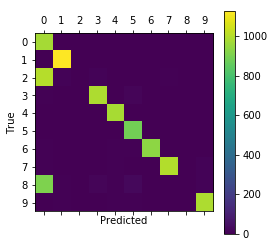

After 100 iterations optimizations:
Optimization Iteration:      1, Training Accuracy:  81.2%
Time usage: 0:00:05
Accuracy on test set:79.2% (7922/10000)
[[ 977    0    0    0    1    0    1    1    0    0]
 [   1 1130    0    2    0    0    0    2    0    0]
 [ 995    6    0   10    5    0    1   14    0    1]
 [   3    0    0 1003    0    2    0    1    0    1]
 [   0    0    0    0  978    0    1    0    0    3]
 [   2    0    0    5    0  879    3    1    0    2]
 [   5    3    0    0    4    1  945    0    0    0]
 [   2    2    0    4    1    0    0 1016    0    3]
 [ 909    5    0   12    8    7    6   10    0   17]
 [   1    3    0    1    5    1    0    4    0  994]]


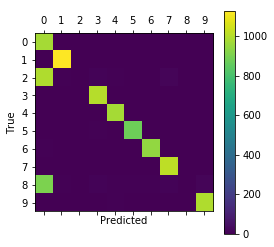

After 1000 iterations optimizations:
Optimization Iteration:    101, Training Accuracy:  71.9%
Optimization Iteration:    201, Training Accuracy:  85.9%
Optimization Iteration:    301, Training Accuracy:  87.5%
Optimization Iteration:    401, Training Accuracy:  81.2%
Optimization Iteration:    501, Training Accuracy:  81.2%


KeyboardInterrupt: 

In [42]:
print("Before optimization accuracy:")
print_test_accuaracy()
print("After 100 iterations optimizations:")
optimize(100)
print_test_accuaracy()
print("After 1000 iterations optimizations:")
optimize(900)
print_test_accuaracy()

After 10000 Iterations training: 
Optimization Iteration:      1, Training Accuracy:  79.7%
Time usage: 0:00:00
Accuracy on test set:79.0% (7905/10000)
[[ 977    0    0    0    0    0    2    0    0    1]
 [   1 1128    0    2    0    1    1    2    0    0]
 [ 987    6    0   22    2    2    5    8    0    0]
 [   3    0    0 1002    0    4    0    1    0    0]
 [   1    0    0    0  968    0    6    3    0    4]
 [   2    0    0    4    0  880    6    0    0    0]
 [   0    2    0    1    1    2  952    0    0    0]
 [   4    1    0    6    0    0    0 1013    0    4]
 [ 885    3    0   36    5   18   19    3    0    5]
 [   2    5    0    5    5    4    0    3    0  985]]


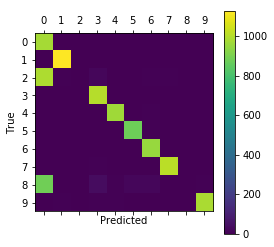

In [43]:
total_iterations = 0
print("After 10000 Iterations training: ")
optimize(1)
print_test_accuaracy(plot_confusion_matrix_=True)

## Exercise

### Exercise 1
Change the learning rate for ths optimizer

### Exercise2
Change the configuration of the layers, such as the number of convolutional filters, the size of those filters, the number of neurons in the fully-connected layer, etc.

### Exercise 3
Add a so-called drop-out layer after the fully-connected layer. Note that the drop-out probability should be zero when calculating the classification accuracy, so you will need a placeholder variable for this probability.

### Exercise 4
Change the order of ReLU and max-pooling in the convolutional layer. Does it calculate the same thing? What is the fastest way of computing it? How many calculations are saved? Does it also work for Sigmoid-functions and average-pooling?